In [1]:
import pickle
import pandas as pd
import numpy as np
from src import subfunc as sf
import warnings
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
DATA_DIR = '../../data/'
DATA = 'evras.csv'
ATOMIC_WEIGHTS_DATA = 'full_atomic_weight.csv'
SOURCE_DIR = '../../source/'
FINAL_STAGE_DIR = 'final_stage/'
target_columns = ['сыпуч известь РП']

In [3]:
data = pd.read_csv(f'{DATA_DIR}{DATA}', index_col='index', sep=';', decimal=',')
atomic_data = pd.read_csv(f'{DATA_DIR}{ATOMIC_WEIGHTS_DATA}', index_col='index', sep=';')

In [4]:
drop_columns = []
for column_name in atomic_data:
    if 1 in atomic_data[column_name].values:
        drop_columns.append(column_name)

In [5]:
atomic_data = atomic_data.drop(columns=drop_columns)

 * Нахождение самой популярной марки

In [6]:
top_mark = data.describe(include='all').loc["top", "МАРКА"]
print("Самая популярная марка - ", top_mark)

Самая популярная марка -  Э76ХФ


* Переводим дату во время изготовления сплава

In [7]:
data['DT'] = sf.date_to_interval(data['DT'])

In [8]:
dropped_data, dropped_columns = sf.drop_columns(data,0.65)
marked_data = dropped_data[dropped_data['МАРКА'] == top_mark]
marked_data = marked_data.drop(columns= ['nplv', 'ПРОФИЛЬ', 'МАРКА'])

Удаленные колонки: N2 (интенс.), расход газ  N2, расход C пров., сыпуч кварцит, сыпуч  кокс. мелочь (сух.), ферспл FeMo, ферспл FeSi-75, ферспл FeV азот., ферспл  Ni H1 пласт., ферспл  ферванит


* Удаляем строки, где пропущены значения для целевых переменных

In [9]:
marked_data = marked_data.dropna(axis = 0,subset = target_columns)

* Заполнение пропущенных значений

In [10]:
marked_data = sf.fill_empty_values(marked_data)

In [11]:
for column_name in dropped_columns:
    if column_name in atomic_data.columns:
        atomic_data.drop(columns=column_name, inplace=True)

In [12]:
marked_data = sf.split_substnce(marked_data, atomic_data)

* Нормализация данных

In [13]:
normalized_data = sf.normalize_data(marked_data.drop(columns=target_columns))
normalized_data[target_columns] = marked_data[target_columns]
del marked_data

In [14]:
normalized_data['categorical_target'] = sf.to_categorical(normalized_data,
                                                          target_columns,
                                                          5,
                                                          f'{DATA_DIR}{FINAL_STAGE_DIR}dict'
                                                          )


In [15]:
#sns_plot = sns.pairplot(normalized_data,
#                    x_vars=normalized_data.columns,
#                    y_vars=target_columns)
#sns_plot.savefig(f'{SOURCE_DIR}{FINAL_STAGE_DIR}multi_map_preprocessing.png')

In [16]:
dispersion = normalized_data.var()
#dispersion_ax = dispersion.sort_values().plot(kind='barh', figsize=(13, 25), grid=True)
#dispersion_fig = dispersion_ax.get_figure()
#dispersion_fig.savefig(f'{SOURCE_DIR}{FINAL_STAGE_DIR}dispersion_bar_preprocessing.png')

In [17]:
columns_to_drop = dispersion[dispersion < 0.001].index.to_list()
normalized_data = normalized_data.drop(columns=columns_to_drop)


In [18]:
corr_data = normalized_data.corr()

In [19]:
#plt.figure(figsize=(52, 50))
#sns.heatmap(corr_data[(corr_data >= 0.5) | (corr_data <= -0.4)],
#       cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.1,
#       annot=True, annot_kws={"size": 8}, square=True)
#plt.savefig(f'{SOURCE_DIR}{FINAL_STAGE_DIR}correlation_map.png')
#plt.show()

In [20]:
corr_target_data = corr_data['сыпуч известь РП']
corr_df = pd.DataFrame(corr_target_data.values, columns=target_columns, index=corr_data.index)
#plt.figure(figsize=(10, 30))
#sns.heatmap(corr_df[(corr_df >= 0.3) | (corr_df <= -0.3)], annot=True, fmt="g", cmap='viridis')
#plt.savefig(f'{SOURCE_DIR}{FINAL_STAGE_DIR}correlation_target_map.png')
#plt.show()

In [21]:
useless_list = []
for ind in corr_data.index:
    for col in corr_data.columns:
        if ind != col and abs(corr_data.loc[ind, col] >= 0.8 ):
            if [col, ind, corr_data.loc[ind, col]] not in useless_list:
                useless_list.append([ind, col, corr_data.loc[ind, col]])

del corr_data
useless_list

[['t обработка', 't продувка', 0.9909186476436075],
 ['t под током', 'эл. энергия', 0.9584710527149887],
 ['чист расход C', 'сыпуч  кокс. мелочь КМ1', 0.828000797897333],
 ['чист расход Cr', 'ферспл  фх850А', 0.997451580263042],
 ['чист расход Mn', 'ферспл SiMn18', 0.9984268985073596],
 ['чист расход Mn', 'ферспл  Mn', 0.9984268985073593],
 ['чист расход Mn', 'ферспл  Si', 0.9984268985073597],
 ['чист расход Si', 'ферспл  Mn5Si65Al0.5', 0.9445660124448018],
 ['чист расход Si', 'ферспл   Mn', 0.9445660124448018],
 ['чист расход Si', 'ферспл   Si', 0.944566012444802],
 ['чист расход Si', 'ферспл   Al', 0.9445660124448018],
 ['Ar (интенс.)', 'расход газ Ar', 0.8322528487336073],
 ['ферспл CaC2', 'ферспл  Ca', 1.0],
 ['ферспл CaC2', 'ферспл  C', 1.0],
 ['ферспл  Mn5Si65Al0.5', 'ферспл   Mn', 1.0000000000000004],
 ['ферспл  Mn5Si65Al0.5', 'ферспл   Si', 1.0000000000000002],
 ['ферспл  Mn5Si65Al0.5', 'ферспл   Al', 1.0],
 ['ферспл SiMn18', 'ферспл  Mn', 1.0],
 ['ферспл SiMn18', 'ферспл  Si',

*  В списке "useless_list" помимо дйствительно коррелирующих признаков есть признаки, которые мы отметили, как ложно-коррелирующие
Список коррелирующих:
 * 'химсталь первый Cr_1', 'химсталь последний Cr'
 * 'химсталь первый Cu_1', 'химсталь последний Cu'
 * 'химсталь первый Mo_1', 'химсталь последний Mo'
 * 'химсталь первый Ni_1', 'химсталь последний Ni'
 * 'химсталь первый P_1', 'химсталь последний P'
 * 'химсталь первый Si_1', 'химсталь последний Si'
 * 't обработка', 't продувка'
 * 't под током', 'эл. энергия'

In [22]:
correlation_list = ['t обработка',
                    't под током',
                    'произв количество обработок',
                    'химсталь первый Cr_1',
                    'химсталь первый Cu_1',
                    'химсталь первый Mo_1',
                    'химсталь первый Ni_1',
                    'химсталь первый P_1',
                    'химсталь первый Si_1'
]

normalized_data = normalized_data.drop(columns=correlation_list)

* Избавляемся от шумов

In [23]:
normalized_data = sf.remove_noises(normalized_data)

* Отбор признаков

In [24]:
normalized_data, features = sf.filter_features(normalized_data.drop(columns=target_columns),
                   normalized_data[target_columns])

D:\kejual projects\Evraz SCC prediction\src\subfunc.py:125: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  regressor.fit(X, Y)


удалили признаков: 69


array([[<AxesSubplot:title={'center':'сыпуч известь РП'}>]], dtype=object)

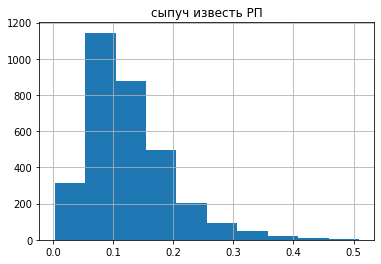

In [25]:
normalized_data[target_columns].hist()


* Разбиение датасета на обучающую и тестовую выборки

In [26]:
test_data = normalized_data.sample(frac= 0.3)
train_data = normalized_data.drop(test_data.index, axis='index')

In [27]:
X_test_data = test_data.drop(columns= target_columns)
labels_test_data = test_data[target_columns]
X_train_data = train_data.drop(columns= target_columns)
labels_train_data = train_data[target_columns]

In [28]:
X_train_data.to_csv(f'{DATA_DIR}{FINAL_STAGE_DIR}x_train.csv', sep = '\t')
X_test_data.to_csv(f'{DATA_DIR}{FINAL_STAGE_DIR}x_test.csv', sep = '\t')
labels_train_data.to_csv(f'{DATA_DIR}{FINAL_STAGE_DIR}y_train.csv', sep = '\t')
labels_test_data.to_csv(f'{DATA_DIR}{FINAL_STAGE_DIR}y_test.csv', sep = '\t')